# Data Preprocessing

After having identified some issues of the training dataset in the EDA phase, we will now proceed to preprocess the data.

In [40]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay

In [41]:
# to be deleted (load the dataset to variable df)
os.chdir('../data')
df = pd.read_csv('customer.csv')

Once the data cleaning process must be applied to both training and test datasets, we will create a function to ensure that we are applying the same transformations to both datasets.

The function must perform the following tasks:
- Remove unnecessary columns
- Deal with outliers
- Scale numerical features (considering Standard Scaling and Min-Max Scaling)
- Encode categorical features (considering Label Encoding and One-Hot Encoding)
- Treat missing values

In [42]:
def preprocess(data, isTest = False):
    """ potentially to be removed 
    # is_employed null values are filled with False
    data['is_employed'] = data['is_employed'].fillna(False)
    """

    # drop columns that are not needed
    cols_to_drop = ['Unnamed: 0','custid','code_column']
    if isTest:
        cols_to_drop.append('health_ins')
    data = data.drop(cols_to_drop, axis=1)

    # change ages < 21 and > 99 to Nan
    data['age'] = data['age'].apply(lambda x: x if 21 <= x <= 99 else None)
    
    # min max scaling
    min_max_columns = ['age', 'num_vehicles', 'rooms']
    minmax_scaler = MinMaxScaler()
    data[min_max_columns] = minmax_scaler.fit_transform(data[min_max_columns]).round(4)
    
    # std scaling
    standard_columns = ['income', 'gas_usage']
    std_scaler = StandardScaler()
    data[standard_columns] = std_scaler.fit_transform(data[['income', 'gas_usage']]).round(4)
    
    # label encoding
    cols_label_encode = ['sex','is_employed', 'state_of_res']
    if not isTest:
        cols_label_encode.append('health_ins')
    label_encoder = LabelEncoder()
    for col in cols_label_encode:
        data[col] = label_encoder.fit_transform(data[col])

    # one hot encoding
    cols_one_hot_encode = ['marital_status', 'housing_type', 'is_employed']
    data = pd.get_dummies(data, columns=cols_one_hot_encode, dummy_na=False)
    dummies = list(filter(lambda x: x.startswith(tuple(cols_one_hot_encode)), data.columns))
    for col in dummies:
        data[col] = label_encoder.fit_transform(data[col])
    
    # scale the state_of_res column
    data['state_of_res'] = MinMaxScaler().fit_transform(data[['state_of_res']])

    # encode recent_move_b with label encoder but keep the Nan values
    data['recent_move_b'] = label_encoder.fit_transform(data['recent_move_b'])
    data['recent_move_b'] = data['recent_move_b'].replace(2, None)

    # use KNN imputation to fill missing data
    knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
    df_imputed = knn_imputer.fit_transform(data)
    df_imputed = pd.DataFrame(df_imputed, columns=data.columns)
    return df_imputed

Now we can apply the preprocessing steps to the training dataset.

In [43]:
df = preprocess(df)
df.head(10)

,sex,income,health_ins,num_vehicles,age,state_of_res,gas_usage,recent_move_b,marital_status_Divorced/Separated,marital_status_Married,marital_status_Never married,marital_status_Widowed,housing_type_Homeowner free and clear,housing_type_Homeowner with mortgage/loan,housing_type_Occupied with no rent,housing_type_Rented,is_employed_0,is_employed_1,is_employed_2
0,1.0,-0.3412,1.0,0.0000,0.0400,0.0,2.6726,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,-0.3206,1.0,0.0000,0.8133,0.0,-0.6054,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,-0.3583,1.0,0.3333,0.1333,0.0,-0.0195,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,-0.0706,1.0,0.1667,0.9600,0.0,1.2474,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,-0.0494,1.0,0.3333,0.6133,0.0,-0.6054,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5,1.0,-0.5282,1.0,0.3333,0.7333,0.0,2.5142,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,-0.2760,0.0,0.3333,0.0667,0.0,-0.6054,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7,0.0,-0.1250,1.0,0.3333,0.6933,0.0,0.1389,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
8,0.0,-0.2897,1.0,0.8333,0.0800,0.0,-0.6054,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
9,1.0,-0.1833,1.0,0.5000,0.4400,0.0,-0.3362,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [44]:
# Columns after preprocessing
df.columns.to_list()

['sex',
 'income',
 'health_ins',
 'num_vehicles',
 'age',
 'state_of_res',
 'gas_usage',
 'recent_move_b',
 'marital_status_Divorced/Separated',
 'marital_status_Married',
 'marital_status_Never married',
 'marital_status_Widowed',
 'housing_type_Homeowner free and clear',
 'housing_type_Homeowner with mortgage/loan',
 'housing_type_Occupied with no rent',
 'housing_type_Rented',
 'is_employed_0',
 'is_employed_1',
 'is_employed_2']

In [45]:
# No missing values
df.isnull().sum().sum()

np.int64(0)

# Model experimentation

In this section, we will experiment, for the first time, some classification models on the preprocessed dataset. 

In order to have a simple baseline, we will employ simple classification algorithms that are easy to interpret and understand. We will use the following models:
- Decision Tree
- Random Forest
- K-Nearest Neighbors

The objective of this section is to get a sense of how the models perform on the dataset to identify potential candidates for further optimization, or find a problem with the data that needs to be addressed before proceeding to more complex models.

We will also perform some hyperparameter tuning on the models to see how their performance can be improved with some optimization. The following parameters will be tuned:
- Decision Tree: `max_depth`
- Random Forest: `n_estimators`
- K-Nearest Neighbors: `n_neighbors`

In order to get some performance metrics, we will divide the training data into a training and validation sets (70% - 30%), and use the valdation set to evaluate the models.

In [46]:
# Split the data into train and test
X = df.drop('health_ins', axis=1)
y = df['health_ins']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

Each model will be evaluated using the following metrics:
- Accuracy
- Precision
- Recall
- F1 Score
- Specificity
- Confusion Matrix

For different hyperparameters, we will store the results in a DataFrame to compare the performance of the models. Then, for the best model of each type, we will store its metrics in another Dataframe to later compare the different algorithms.

In [47]:
# Function to, given the prediction of a model, return its performance metrics
def get_metrics(y_pred):
    acc = round(accuracy_score(y_test, y_pred),3)
    prec = round(precision_score(y_test, y_pred),3)
    rec = round(recall_score(y_test, y_pred),3)
    f1 = round(f1_score(y_test, y_pred),3)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    spec = round(tn / (tn+fp),3)
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'specificity': spec, 'cm': cm}

In [48]:
models = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])

For a better visualization of hyperparameters impact on the performance of these models, we will plot the performance metrics for different values of the hyperparameters using the following function:

In [49]:
def plot_measures(measures):
    parameters = measures.iloc[:,0]
    accuracy = measures.iloc[:,1]
    precision = measures.iloc[:,2]
    recall = measures.iloc[:,3]
    f1 = measures.iloc[:,4]
    spec = measures.iloc[:,5]

    sns.lineplot(x=parameters, y=accuracy, label='accuracy')
    sns.lineplot(x=parameters, y=precision, label='precision')
    sns.lineplot(x=parameters, y=recall, label='recall')
    sns.lineplot(x=parameters, y=f1, label='f1')
    sns.lineplot(x=parameters, y=spec, label='specificity')

## Decision Tree

Fitting model with 1
Fitting model with 3
Fitting model with 5
Fitting model with 7
Fitting model with 9
Fitting model with 11
Fitting model with 13
Fitting model with 15
Fitting model with 17
Fitting model with 19
Fitting model with None
None generates the following depth: 35


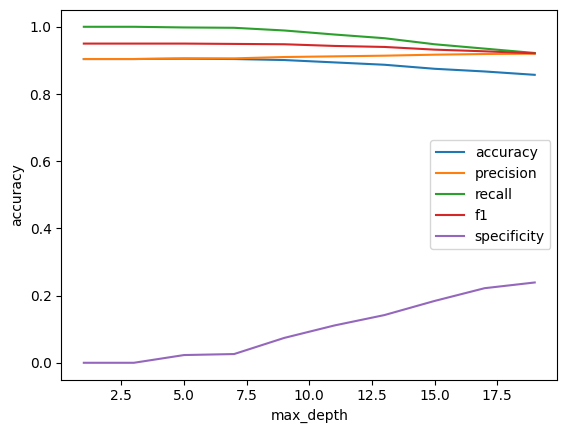

In [50]:
dt_measures = pd.DataFrame(columns=['max_depth', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])
parameters = list(range(1, 20, 2)) + [None]

for max_depth in parameters:
    print(f'Fitting model with {max_depth}')
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    measures = get_metrics(y_pred)
    new_row = {'max_depth': max_depth, **measures}
    dt_measures.loc[len(dt_measures)] = new_row

    if max_depth == None:
        print(f'None generates the following depth: {model.get_depth()}')


plot_measures(dt_measures)

In [51]:
# Choose decision tree with max_depth = 9
row = dt_measures[dt_measures['max_depth'] == 9]
models.loc[len(models)] = {'model': 'Decision Tree', **row.iloc[0,1:]}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.901,0.91,0.989,0.948,0.074,"[[153, 1923], [221, 19441]]"


## Random Forest

Fitting model with 10
Fitting model with 20
Fitting model with 50
Fitting model with 75
Fitting model with 100
Fitting model with 200
Fitting model with 500


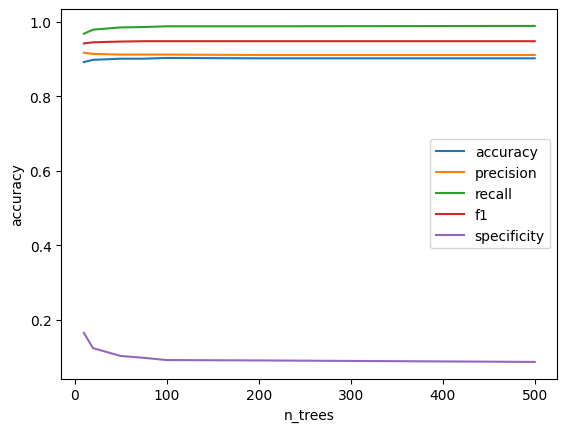

In [52]:
rf_measures = pd.DataFrame(columns=['n_trees', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])
parameters = [10, 20, 50, 75, 100, 200, 500]

for n_trees in parameters:
    print(f'Fitting model with {n_trees}')
    model = RandomForestClassifier(n_estimators=n_trees)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    measures = get_metrics(y_pred)
    new_row = {'n_trees': n_trees, **measures}
    rf_measures.loc[len(rf_measures)] = new_row

plot_measures(rf_measures)

In [53]:
# Choose random forest with n_trees = 100
row = rf_measures[rf_measures['n_trees'] == 100]
models.loc[len(models)] = {'model': 'Random Forest', **row.iloc[0,1:]}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.901,0.910,0.989,0.948,0.074,"[[153, 1923], [221, 19441]]"
1,Random Forest,0.903,0.912,0.988,0.948,0.092,"[[190, 1886], [230, 19432]]"


## K-Nearest Neighbors

Fitting model with 3
Fitting model with 5
Fitting model with 7
Fitting model with 9
Fitting model with 11
Fitting model with 13
Fitting model with 15
Fitting model with 17
Fitting model with 19
Fitting model with 21
Fitting model with 23


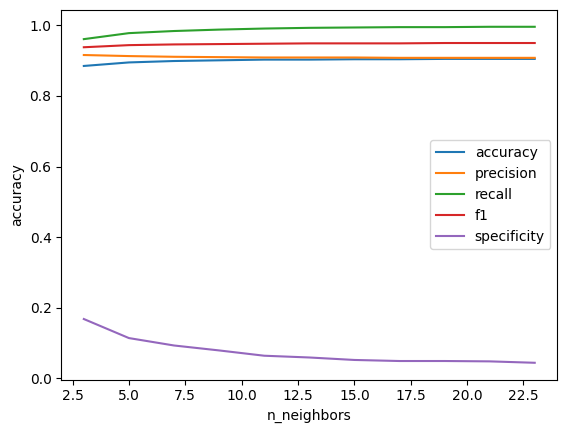

In [54]:
knn_measures = pd.DataFrame(columns=['n_neighbors', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])
parameters = list(range(3, 25, 2))

for n_neighbors in parameters:
    print(f'Fitting model with {n_neighbors}')
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    measures = get_metrics(y_pred)
    new_row = {'n_neighbors': n_neighbors, **measures}
    knn_measures.loc[len(knn_measures)] = new_row

plot_measures(knn_measures)

In [55]:
# Choose KNN with n_neighbors = 11
row = knn_measures[knn_measures['n_neighbors'] == 11]
models.loc[len(models)] = {'model': 'KNN', **row.iloc[0,1:]}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.901,0.910,0.989,0.948,0.074,"[[153, 1923], [221, 19441]]"
1,Random Forest,0.903,0.912,0.988,0.948,0.092,"[[190, 1886], [230, 19432]]"
2,KNN,0.903,0.909,0.991,0.948,0.064,"[[132, 1944], [175, 19487]]"


## Overall comparison of the models

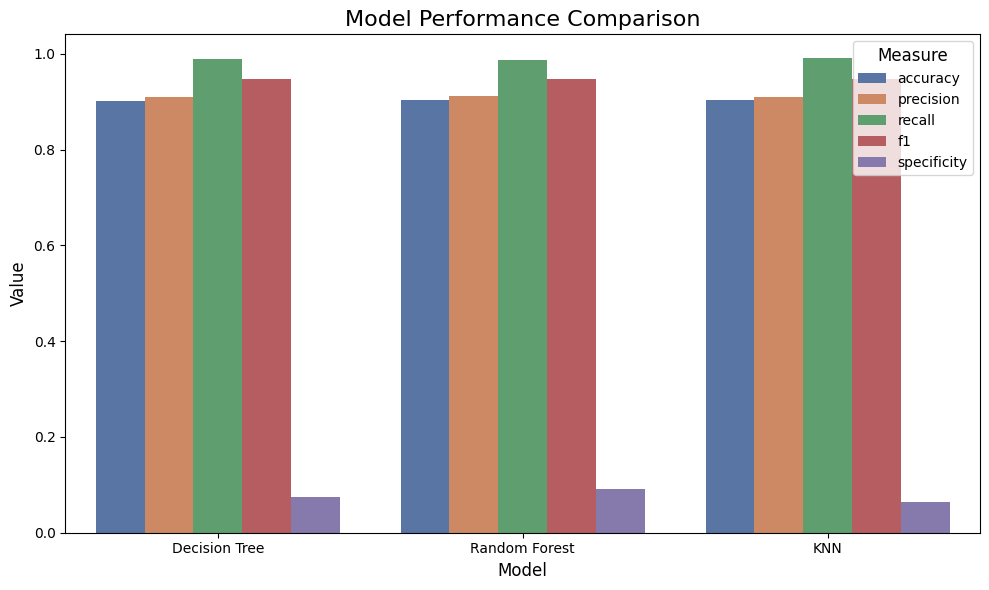

In [56]:
melted = models.melt(id_vars="model", value_vars=["accuracy", "precision", "recall", "f1", "specificity"],
                     var_name="measure", value_name="value")

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x="model", y="value", hue="measure", palette="deep")
plt.title("Model Performance Comparison", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Measure", fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

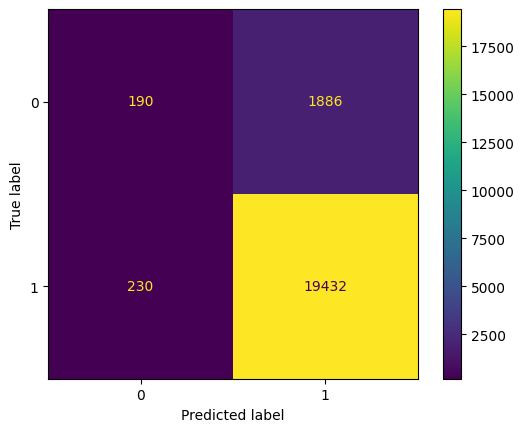

In [57]:
# plot confusion matrix of random forest
rf_cm = models[models['model'] == 'Random Forest']['cm'].values[0]
ConfusionMatrixDisplay(rf_cm).plot()

As we can see, these models seem to perform very well. All of them achieve accuracy, F1-score, recall and precision around 0.9.

Does this mean that we can move forward to more complex models? Not at all.
All these models are getting very low values for specificity and very few cases of True Negatives, meaning they are not good at capturing the negative class. This indicates the presence of very underfitted models, biased towards the positive class.

The confusion matrices resulting of each of these models prove that these models are not capable of correclty predicting a considerbale amount of negative cases.

In [25]:
# Frequency of target variable
print(y.value_counts())

# Frequency of target variable in percentage
print(y.value_counts(normalize=True))

health_ins
1.0    65553
0.0     6905
Name: count, dtype: int64
health_ins
1.0    0.904703
0.0    0.095297
Name: proportion, dtype: float64


Once we are using the trainig dataset to both train and validate our models, the "classical" metrics are not enough to reason about model performance. 

This dataset is highly imbalanced, meaning that both test and validation partitions (generated from itself) will have a similar distribution. So, if we use a model that learns to predict everything as positive, when tested in a dataset with similar distribution, it will achieve very good accuracy, F1, ... metrics.

In [26]:
# Frequency of target variable in train partition
print(y_train.value_counts(dropna=False, normalize=True))

# Frequency of target variable in test partition
print(y_test.value_counts(dropna=False, normalize=True))

health_ins
1.0    0.904791
0.0    0.095209
Name: proportion, dtype: float64
health_ins
1.0    0.904499
0.0    0.095501
Name: proportion, dtype: float64


Next section will focus on how to address this issue, by aplying balacing techniques to the dataset.